In [3]:
import pyterrier as pt
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from transformers import BertModel
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from model.Train import Trainer
from model.Loss import LSmoothing, WSLSmoothing
from model.Bert import BertForQuestionPairClassification
from model.DataManager import QuoraDataset
from transformers import BertTokenizer
from model.NegativeSampling import RandomSampling, BM25Sampling

In [1]:
!pip install python-terrier
# !apt-get install java

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 847.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setu

In [ ]:
!ls -la /usr/lib/jvm/java-11-openjdk-amd64
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

total 32
drwxr-xr-x  7 root root 4096 Apr 17 20:25 .
drwxr-xr-x  3 root root 4096 Apr 17 20:25 ..
drwxr-xr-x  2 root root 4096 Apr 17 20:25 bin
drwxr-xr-x  4 root root 4096 Apr 17 20:25 conf
lrwxrwxrwx  1 root root   42 Jan 20 10:27 docs -> ../../../share/doc/openjdk-11-jre-headless
drwxr-xr-x 73 root root 4096 Apr 17 20:25 legal
drwxr-xr-x  6 root root 4096 Apr 17 20:25 lib
drwxr-xr-x  4 root root 4096 Apr 17 20:25 man
-rw-r--r--  1 root root 1250 Jan 20 10:27 release


In [4]:
if not pt.started():
   pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])
pd.set_option('display.max_colwidth', 150)

terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done
terrier-prf -SNAPSHOT jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def load_data(path,size=None):
    data = pd.read_csv(path)
    data = data.dropna() 
    data = data[data['is_duplicate'] == 1]
    data = data.sample(size) if size else data
    data.drop(columns=data.columns[:3],inplace=True)
    return data

def split_data(data, test_size=0.1, val_size=0.1):
    train_val, test = train_test_split(data, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size), random_state=42)
    return train, val, test

def index_data(df, type_df="train"):
    # Indexer les données (dataframe) pour l'entrainement
    indexer = pt.DFIndexer("./index_" + type_df, overwrite=True)
    data_to_index = df.copy()
    data_to_index['docno'] = data_to_index['global_docno']
    index_ref = indexer.index(data_to_index['question1'], data_to_index['question2'], data_to_index['docno'])
    return index_ref

def tokenize_questions(question1, question2, max_length=128):
    # prendre un échantillon de taille size car il y'a 400k+ lignes
    return tokenizer(question1, question2, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
from torch.utils.data import Dataset
import torch


class QuoraDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Récupérer une ligne du dataframe
        row = self.data.iloc[idx]
        # Tokenizer les questions 1 et 2 
        inputs = self.tokenizer(row['question1'], row['question2'],
                                padding='max_length', max_length=self.max_length, truncation=True)
        inputs = {key: torch.tensor(val) for key, val in inputs.items()}
        # Récupérer le label et le score
        label = torch.tensor(row['is_duplicate'])
        score = torch.tensor(row['score'], dtype=torch.float)
        return inputs, label, score


In [42]:
import re
class RandomSampling():
    @staticmethod
    def sample(data, k=2):
        if 'is_duplicate' not in data.columns:
            raise ValueError("Input dataframe must contain 'is_duplicate' column.")
        if k <= 0:
            raise ValueError("Parameter k must be a positive integer.")

        # Ajout d'une colonne score avec des valeurs aléatoires.
        data['score'] = np.random.uniform(0, 1, size=len(data))
        
        # garder que les query avec is_duplicate = 1
        duplicates = data[data['is_duplicate'] == 1]

        # Initialisation des listes pour stocker les nouvelles paires
        new_question1 = []
        new_question2 = []
        new_labels = []
        random_scores = []

        # Choisir au maximum k paires pour éviter des boucles inefficaces.
        if len(duplicates) < k:
            k = len(duplicates)

        # Utilisation de sample sans remplacement pour toute la liste en une seule fois.
        sampled_indices = np.random.choice(duplicates.index, size=k, replace=False)
        sampled_duplicates = duplicates.loc[sampled_indices]

        # Comparer chaque élément avec tous les autres, exclure la comparaison avec lui-même.
        for i, row_i in sampled_duplicates.iterrows():
            for j, row_j in sampled_duplicates.iterrows():
                if i != j:
                    new_question1.append(row_i['question1'])
                    new_question2.append(row_j['question2'])
                    new_labels.append(0)  # Ces paires sont des non-duplicatas.
                    random_scores.append(np.random.uniform(0, 1))

        # Création du nouveau DataFrame avec les paires augmentées.
        augmented_data = pd.DataFrame({
            'question1': new_question1,
            'question2': new_question2,
            'is_duplicate': new_labels,
            'score': random_scores
        })

        final_df = pd.concat([data, augmented_data], ignore_index=True)
        final_df = final_df.drop(columns="global_docno", errors="ignore")
        return final_df

class BM25Sampling():
    @staticmethod
    def preprocess_query(query):
        # Préprocess simple
        query = query.lower()
        query = re.sub(r'[^\w\s]', '', query) 
        return query
    
    @staticmethod
    def sample(index_ref, data, k=2):
        index = pt.IndexFactory.of(index_ref)
        bm25 = pt.BatchRetrieve(index, wmodel="BM25", metadata=['docno'])
        
        new_questions = []
        # Sur les query avec is_duplicate = 1
        duplicates = data[data['is_duplicate'] == 1]
        for _, row in duplicates.iterrows():
            # faire une requete pour avoir les top k des questions 2 similaires
            query_df = pd.DataFrame({'query': [BM25Sampling.preprocess_query(row['question1'])], 'qid': [1]})
            results = bm25.transform(query_df)
            # verifié que les questions ne sont pas les mêmes + que le docno est dans global_docno (indice global avant le split du dataset)
            valid_results = results[results['docno'].isin(data['global_docno']) & (results['docno'] != row['global_docno'])].head(k)
            for _, result in valid_results.iterrows():
                matched_row = data[data['global_docno'] == result['docno']].iloc[0]
                new_questions.append({
                    'question1': row['question1'],
                    'question2': matched_row['question2'],
                    'is_duplicate': 0,
                    'score': result['score'] if pd.notna(result['score']) else np.random.uniform()
                })
        augmented_data = pd.DataFrame(new_questions)
        final_df = pd.concat([data, augmented_data], ignore_index=True)

        # normaliser les scores entre 0 et 1 
        if 'score' in final_df:
            final_df['score'].fillna(final_df.apply(lambda x: np.random.uniform() if x['is_duplicate'] == 0 else 1, axis=1), inplace=True)
            max_score = final_df['score'].max()
            min_score = final_df['score'].min()
            if max_score > min_score:  
                final_df['score'] = (final_df['score'] - min_score) / (max_score - min_score)
            else:
                final_df['score'] = 0.0  

        final_df = final_df.drop(columns="global_docno")
        return final_df

In [22]:
import torch.nn.functional as F

class BertForQuestionPairClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
        # layer de dropout pour éviter overfitting, car le modèle overfit très rapidement
        self.dropout = nn.Dropout(0.1)


    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)
        return logits

class LSmoothing(nn.Module):
    def __init__(self, epsilon=0.1, num_classes=2):
        super().__init__()
        self.epsilon = epsilon
        self.num_classes = num_classes

    def forward(self, outputs, targets, ns_scores = None, epsilon=0.1, return_sl=False):
        batch_size = targets.size(0)
        smoothed_labels = torch.full((batch_size, self.num_classes), epsilon / (self.num_classes - 1), device=outputs.device)
        targets_one_hot = torch.zeros_like(smoothed_labels)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1.0)
        smoothed_labels = (1 - epsilon) * targets_one_hot + epsilon * smoothed_labels

        # A utlilisé pour WSLS
        if return_sl:
            return smoothed_labels
        
        # Calculer la cross-entropy avec les "smoothed labels"
        log_probs = F.log_softmax(outputs, dim=1)
        loss_fn = nn.KLDivLoss(reduction='batchmean')
        return loss_fn(log_probs, smoothed_labels)
    
    
class WSLSmoothing(nn.Module):

    def __init__(self, nb_labels=2, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.ls = LSmoothing(nb_labels)
        self.num_classes = 2
        
    def forward(self, outputs, targets, ns_scores, smoothing=0.1):
        ns_scores = ns_scores.unsqueeze(-1)  # Ensure ns_scores is always [N, 1]

        # Récuperé les smoothed_labels
        smoothed_labels = self.ls(outputs, targets, epsilon=smoothing, return_sl=True)
        adjusted_labels = smoothed_labels.clone() 

        # Indices des classe negative
        neg_indices = targets == 0

        # Ajusté les poids des classes négatives avec les scores de NS (formule du papier)
        adjusted_labels[neg_indices, 0] = (1 - smoothing) * ns_scores[neg_indices].squeeze(-1) + smoothing / (self.num_classes - 1)
        adjusted_labels[neg_indices, 1] = (1 - smoothing) * (1 - ns_scores[neg_indices].squeeze(-1)) + smoothing / (self.num_classes - 1)

        # Calculer la cross-entropy avec les "adjusted labels"
        loss_fn = nn.CrossEntropyLoss()
        return loss_fn(outputs, adjusted_labels)

In [69]:
import torch
from torch.utils.data import DataLoader

class Trainer:
    """Class pour entrainer un modèle.
    """
    def __init__(self) -> None:
        self.model : torch.nn.Module = None
        self.train_loader : DataLoader = None
        self.val_loader : DataLoader = None
        self.loss_fn : torch.nn.Module = None
        self.optimizer : torch.optim.Optimizer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.history = {
            "validation": {
                "accuracy": [],
                "loss": [],
                "precision": [],
                "recall": []
            },
            "training": {
                "accuracy": [],
                "loss": [],
                "precision": [],
                "recall": []
            },
            "params": {
                "learning_rate": None,
                "weight_decay": None,
                "epochs": None,
                "smoothing" : None,
            }
        }

    def save_model(self, path : str = "model.pth", history_path : str = "history.txt"):
        print("Saving the model...")
        torch.save(self.model.state_dict(), path)
        torch.save(self.history, history_path)
        print("Model saved.")

    def set_optimizer(self, optimizer : str):
        self.optimizer : torch.optim.Optimizer = optimizer
        return self
    
    def set_model(self, model : torch.nn.Module):
        self.model = model
        return self
    
    def set_loader(self, train_loader : DataLoader, val_loader : DataLoader | None, test_loader : DataLoader | None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        return self
    
    def set_loss_fn(self, loss_fn : torch.nn.Module):
        self.loss_fn = loss_fn
        return self
    
    def train(self):
        """Méthode pour entrainer le modèle"""
        print("Training...")
        self.model.train()
        train_loss = 0
        for inputs, labels, ns_scores in self.train_loader:
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            labels = labels.to(self.device)
            ns_scores = ns_scores.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(**inputs)
            loss = self.loss_fn(outputs, labels, ns_scores, self.smoothing)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
        return train_loss
    
    def validate(self):
        """Méthode pour valider le modèle"""
        print("Validating...")
        self.model.eval()
        with torch.no_grad():
            val_loss = 0
            for inputs, labels, ns_scores in self.val_loader:
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                labels = labels.to(self.device)
                ns_scores = ns_scores.to(self.device)
                outputs = self.model(**inputs)
                loss = self.loss_fn(outputs, labels, ns_scores, self.smoothing)
                val_loss += loss.item()
            return val_loss
        
    def fit(self, learning_rate = 1e-4, epochs : int = 100, weight_decay : float = 0.01, smoothing : float = 0.1, CL=False):
        """Method to train the model.
        @param learning_rate : float, The learning rate for the optimizer.
        @param epochs : int, The number of epochs for training the model.
        """
        print(f"Training the model on {self.device}...")
        self.model.to(self.device)
        self.smoothing = smoothing
        self.optimizer = self.optimizer(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.history["params"]["learning_rate"] = learning_rate
        self.history["params"]["weight_decay"] = weight_decay
        self.history["params"]["epochs"] = epochs
        self.history["params"]["smoothing"] = smoothing

        val_loss, train_loss = [], []
        for epoch in range(epochs):
            train_loss_epoch = self.train()
            if self.val_loader is not None:
                val_loss_epoch = self.validate()
                val_loss.append(val_loss_epoch / len(self.val_loader))

            train_loss.append(train_loss_epoch/len(self.train_loader))

            # for curriculum learning, mettre le smoothing à 0 (two-stage training selon le papier)
            if CL and epoch == epochs//2:
                self.smoothing = 0.0

            print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

        print("Training complete.")
        self.history["training"]["loss"] = train_loss
        self.history["validation"]["loss"] = val_loss

        return self.history

In [70]:
path = '/content/data/questions.csv'
bs = 32
bm25_sampling = True

data = load_data(path, 1000)
data['global_docno'] = data.index.astype(str)
train_data, val_data, test_data = split_data(data)
if bm25_sampling :
    index_ref_tr = index_data(train_data,type_df="train_7")
    index_ref_val = index_data(val_data,type_df="val_7")
    index_ref_test = index_data(test_data,type_df="test_7")
    train_data = BM25Sampling.sample(index_ref_tr,train_data, k=9).sort_values(by="question1")
    val_data = BM25Sampling.sample(index_ref_val,val_data, k=9).sort_values(by="question1")
    test_data = BM25Sampling.sample(index_ref_test,test_data, k=9).sort_values(by="question1")
else:
    train_data = RandomSampling.sample(train_data, k=9).sort_values(by="question1")
    val_data = RandomSampling.sample(val_data, k=9).sort_values(by="question1")
    test_data = RandomSampling.sample(test_data, k=9).sort_values(by="question1")

train_dataset = QuoraDataset(train_data, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dataset = QuoraDataset(val_data, tokenizer, max_length=128)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_dataset = QuoraDataset(test_data, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [71]:
print(train_data.shape,test_data.shape,val_data.shape)

(6932, 4) (561, 4) (586, 4)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 5
learning_rate = 1e-4

model = BertForQuestionPairClassification()
model = model.to(device)
optimizer = torch.optim.AdamW
loss = LSmoothing()
trainer = Trainer()
history = trainer.set_model(model)\
    .set_loader(train_loader, val_loader, None)\
    .set_loss_fn(loss)\
    .set_optimizer(optimizer)\
    .fit(learning_rate, epochs, CL=False)

Training the model on cuda...
Training...
Validating...
Epoch [1/5], Training Loss: 0.09063547661888503, Validation Loss: 0.10122150464093913
Training...
Validating...
Epoch [2/5], Training Loss: 0.03605138586859824, Validation Loss: 0.0026822320809114283
Training...


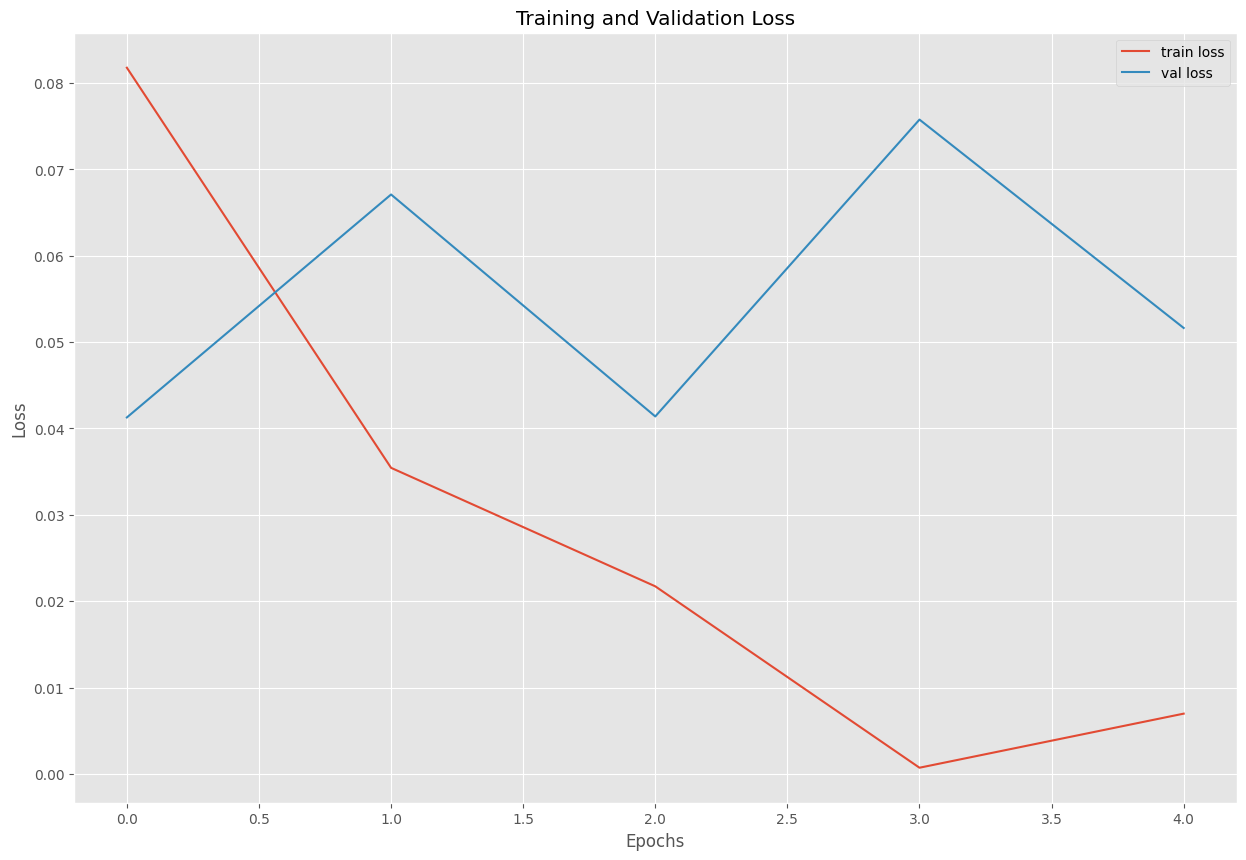

In [67]:
train_loss = history['training']['loss']
val_loss = history['validation']['loss']

plt.style.use('ggplot')
plt.figure(figsize=(15,10))
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [68]:
def recall_at_k(all_scores, all_targets, K, num_duplicate):
    top_k_indices = np.argsort(all_scores)[::-1][:K]
    top_k_targets = all_targets[top_k_indices]
    recall = np.sum(top_k_targets) / num_duplicate
    return recall

def evaluate_ranking_model(model, data_loader, K, device):
    model.eval()
    model.to(device)
    recalls = []
    with torch.no_grad():
        for inputs, labels, ns_scores in data_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            ns_scores = ns_scores.to(device)
            outputs = model(**inputs)
            scores = torch.softmax(outputs, dim=1)[:, 1] 
            scores = scores.cpu().numpy()
            targets = labels.cpu().numpy()
            num_duplicate = np.sum(targets)  
            if num_duplicate == 0:
                continue  
            recall_k = recall_at_k(scores, targets, K, num_duplicate)
            recalls.append(recall_k)

    # Average over all queries
    avg_recall = np.mean(recalls)
    return {
        f"recall_at_{K}": avg_recall
    }

metrics = evaluate_ranking_model(model, test_loader, K=1, device=device)
print("Ranking Metrics:", metrics)

Ranking Metrics: {'recall_at_1': 0.6657407407407407}


In [ ]:
trainer.save_model()